In [ ]:

from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset
from FeGdSpinGNN.augmentation import RandomRotationTransform


#Code to load in the data with system indices for train, val, test splits
rotation_transform = RandomRotationTransform
cutoff_distance = 0.3

dataset_train = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,
        transform_rotate=rotation_transform 
    )

dataset_val = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[6, 7],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,  
    )

dataset_test = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[8, 9],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,  
    )

# Apply to loaded datasets
dataset_test[0]

Loading systems: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Data(x=[800, 5], edge_index=[2, 9424], edge_attr=[9424, 4], y=[800, 3], pos=[800, 3], system_id=8, timestep=0)

In [1]:
import torch
from torch.utils.data import random_split
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset
from FeGdSpinGNN.augmentation import RandomRotationTransform

rotation_transform = RandomRotationTransform
cutoff_distance = 0.3


dataset_tot = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5, 6, 7, 8, 9],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,
        transform_rotate=rotation_transform  
    )

n_total = len(dataset_tot)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

dataset_train, dataset_val, dataset_test = random_split(
    dataset_tot,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)



Loading systems: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


In [2]:
from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

# stats = compute_normalization_stats(dataset_train)
# train_normalized = [normalize_data(data, stats) for data in dataset_train]
# val_normalized = [normalize_data(data, stats) for data in dataset_val]
# test_normalized = [normalize_data(data, stats) for data in dataset_test]

In [2]:
from FeGdSpinGNN_NonEqui.FeGd_normalizer import FeGdNormalizer

normalizer = FeGdNormalizer().fit(dataset_train)

train_normalized = [normalizer.normalize(data) for data in dataset_train]
val_normalized = [normalizer.normalize(data) for data in dataset_val]
test_normalized = [normalizer.normalize(data) for data in dataset_test]

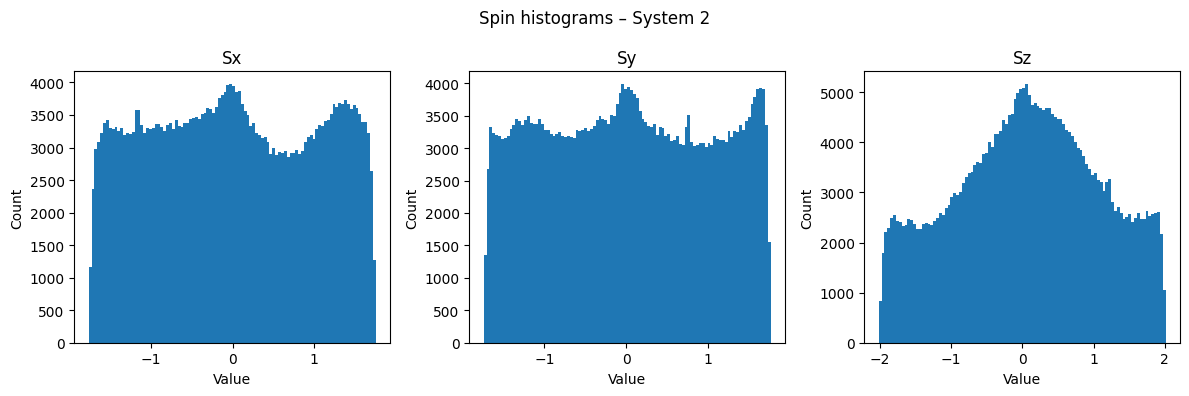

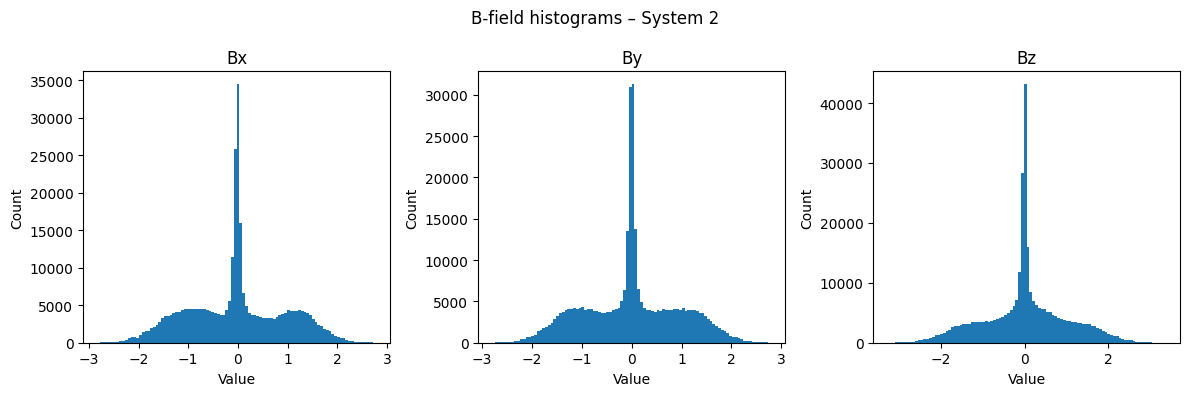

In [3]:
from FeGdSpinGNN_NonEqui.common.utils import plot_spin_B_histograms
plot_spin_B_histograms(train_normalized, systems=[2], bins=100)

In [4]:
from torch_geometric.loader import DataLoader
batch_size = 16

train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import torch.optim as optim
from FeGdSpinGNN_NonEqui.models.InvariantFeGdFieldModel import InvariantFeGdBFieldModel
from FeGdSpinGNN_NonEqui.models.baseline_gnn import NaiveFeGdBFieldModel
import torch.nn as nn

# Initialize model
model = NaiveFeGdBFieldModel(
    node_in_dim=5,      
    hidden_dim=32,     
    num_layers=2,       
    dropout=0.2         
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=10,
    factor=0.5,
    min_lr=1e-6
)

In [6]:
from FeGdSpinGNN_NonEqui.FeGd_trainer import mse_loss, BFieldTrainer

trainer = BFieldTrainer(
    model=model,
    device=device,
    optimizer=optimizer,
    lambda_angle=0.0,  
)

In [7]:
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=3,
)

Epoch   1/3 | Train 0.515895 | Val 0.255720 | MSE 0.255720 | Angle 46.22°Magmae 0.471146 | 


Epoch   2/3 | Train 0.249609 | Val 0.208570 | MSE 0.208570 | Angle 43.90°Magmae 0.334871 | 


Epoch   3/3 | Train 0.226938 | Val 0.200284 | MSE 0.200284 | Angle 40.83°Magmae 0.310482 | 


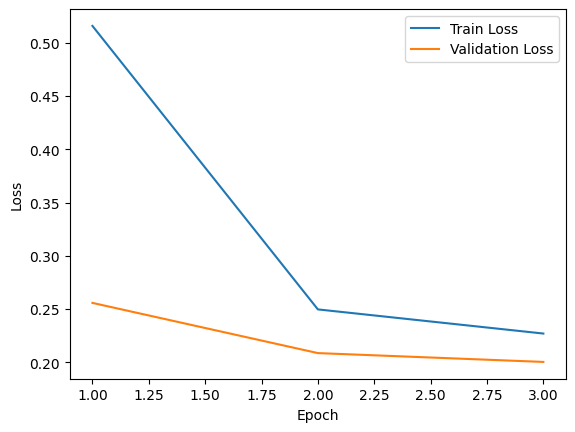

In [8]:
from FeGdSpinGNN_NonEqui.common.utils import plot_correlation, training_plot, plot_true_pred_B_fields
training_plot(num_epochs=len(history['train_loss']), train_losses=history['train_loss'], val_losses=history['val_loss'])

In [9]:
# Evaluate on test set
_, _, test_mse, _ = trainer.evaluate(test_loader)
print(f"Test MSE Loss: {test_mse:.6f}")


Test MSE Loss: 0.199949


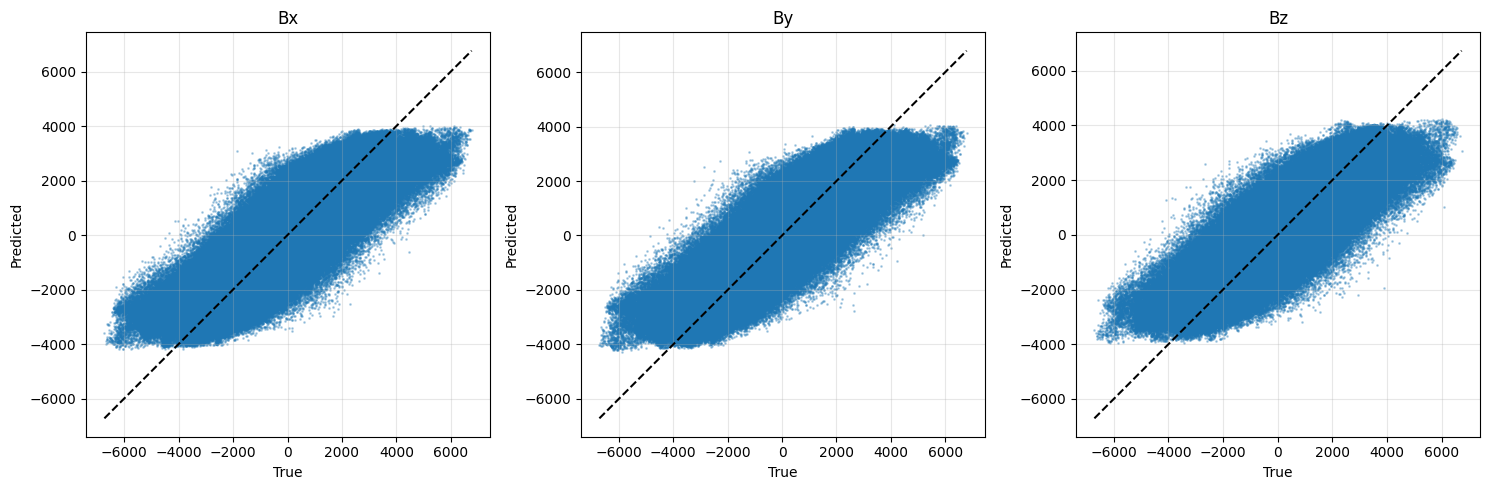

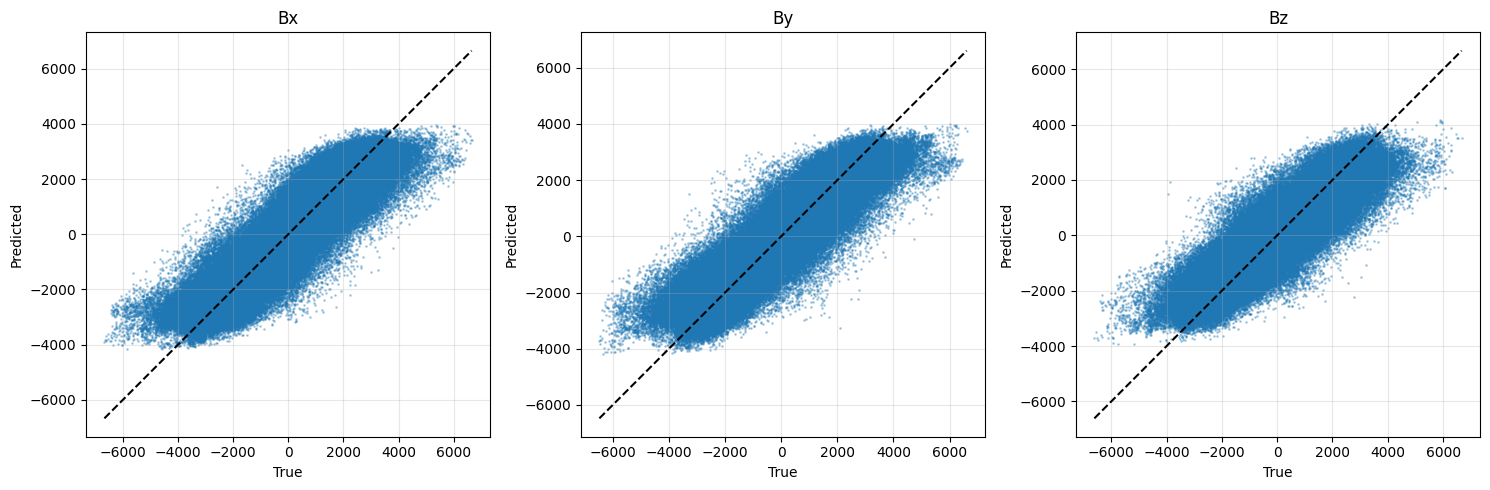

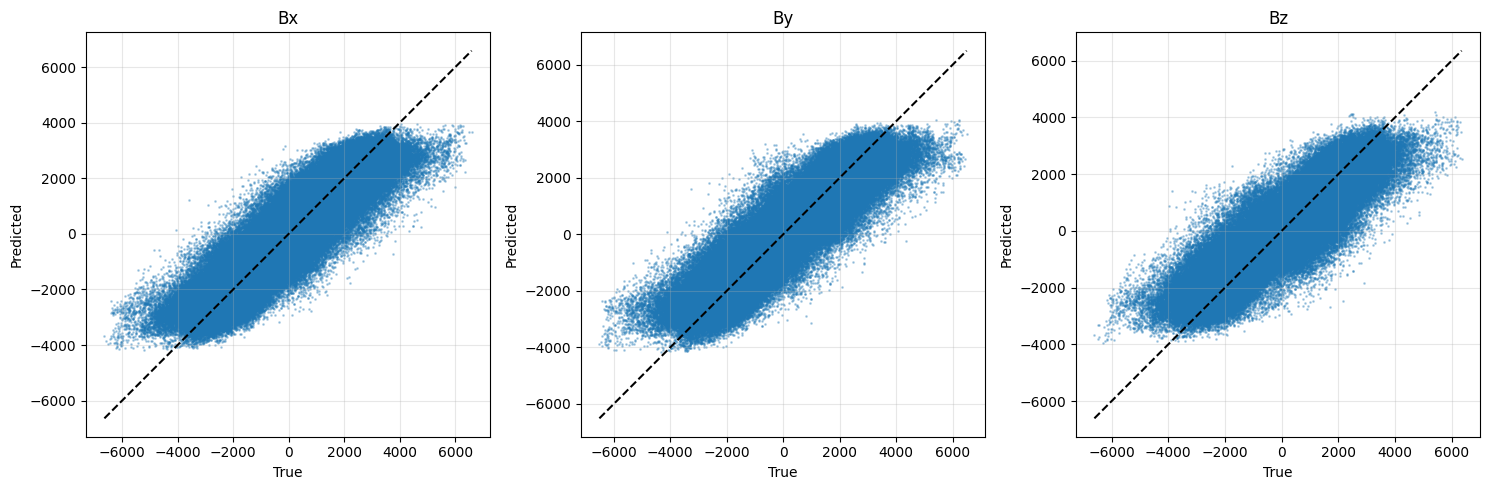

In [10]:
plot_correlation(model, train_loader, device, normalizer=normalizer)
plot_correlation(model, val_loader, device, normalizer=normalizer)
plot_correlation(model, test_loader, device, normalizer=normalizer)

In [14]:
from FeGdSpinGNN_NonEqui.common.utils import evaluate_physical_metrics

test_metrics = evaluate_physical_metrics(
    model,
    test_loader,
    device,
    normalizer
)

print("\nTest Set Metrics (Physical Units):")
print(f"  MSE:  {test_metrics['mse']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE:  {test_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{test_metrics['mse_x']:.6f}, "
    f"{test_metrics['mse_y']:.6f}, "
    f"{test_metrics['mse_z']:.6f}"
)

val_metrics = evaluate_physical_metrics(
    model,
    val_loader,
    device,
    normalizer
)
print("\nVal Set Metrics (Physical Units):")
print(f"  MSE:  {val_metrics['mse']:.6f}")
print(f"  RMSE: {val_metrics['rmse']:.6f}")
print(f"  MAE:  {val_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{val_metrics['mse_x']:.6f}, "
    f"{val_metrics['mse_y']:.6f}, "
    f"{val_metrics['mse_z']:.6f}"
)

train_metrics = evaluate_physical_metrics(
    model,
    train_loader,
    device,
    normalizer
)

print("\nTrain Set Metrics (Physical Units):")
print(f"  MSE:  {train_metrics['mse']:.6f}")
print(f"  RMSE: {train_metrics['rmse']:.6f}")
print(f"  MAE:  {train_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{train_metrics['mse_x']:.6f}, "
    f"{train_metrics['mse_y']:.6f}, "
    f"{train_metrics['mse_z']:.6f}"
)


Test Set Metrics (Physical Units):
  MSE:  567260.937500
  RMSE: 753.167297
  MAE:  529.411438
  MSE (Bx, By, Bz): 567318.437500, 572008.062500, 562456.250000

Val Set Metrics (Physical Units):
  MSE:  565125.937500
  RMSE: 751.748596
  MAE:  529.389587
  MSE (Bx, By, Bz): 551853.687500, 605797.875000, 537726.187500

Train Set Metrics (Physical Units):
  MSE:  556820.875000
  RMSE: 746.204285
  MAE:  525.667664
  MSE (Bx, By, Bz): 559427.812500, 575359.187500, 535675.625000


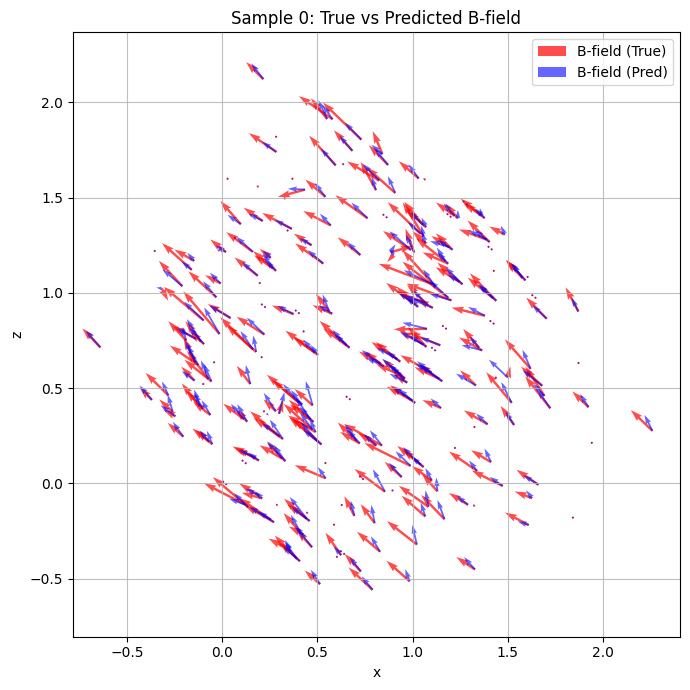

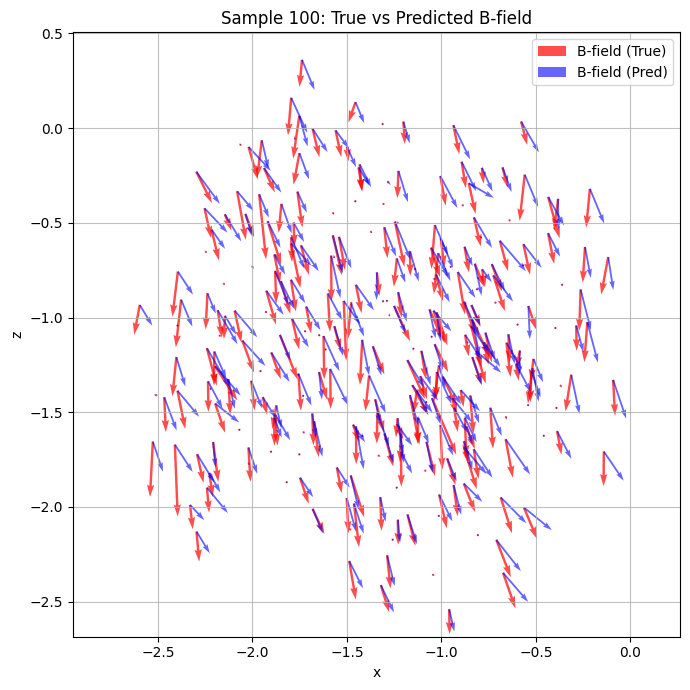

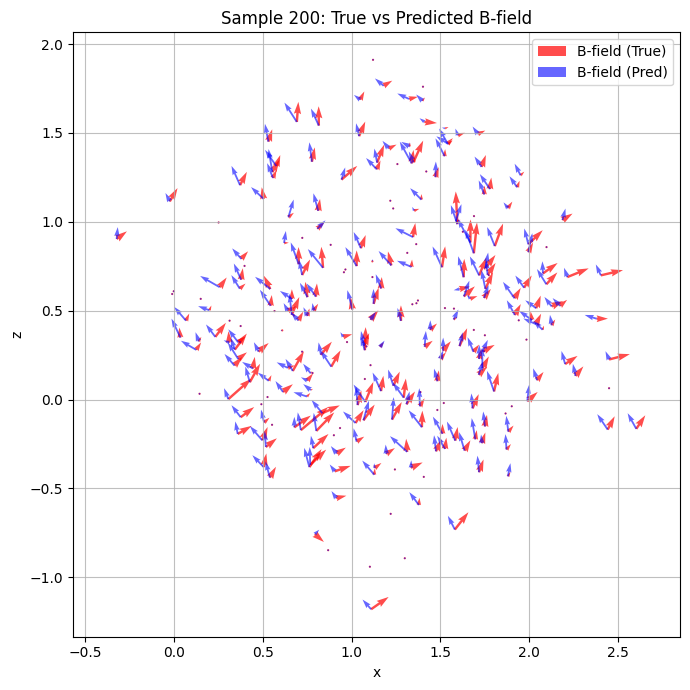

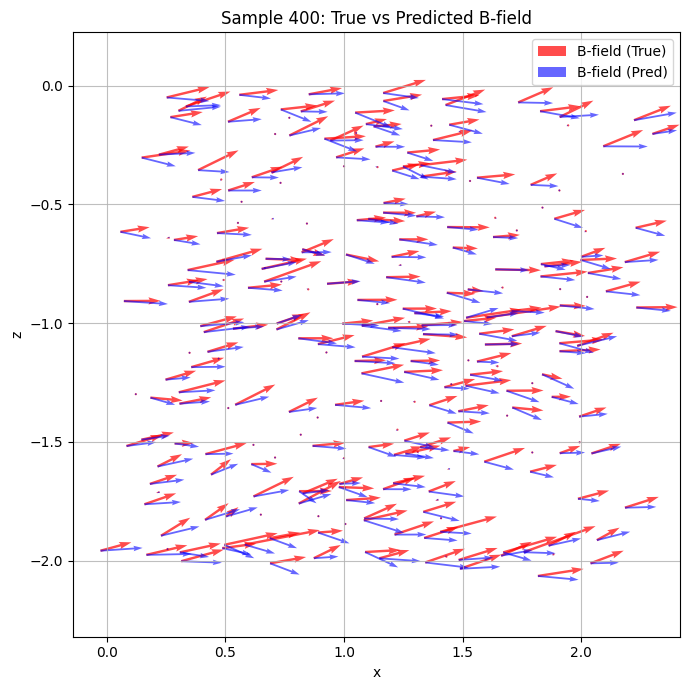

In [15]:
test_indices = [0, 100, 200, 400]#, 400]
plot_true_pred_B_fields(model, test_normalized, test_indices,
                       normalizer, scale_B=50000, device=device)